In [10]:
world = 5
import networks
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
angle_right_recording, angle_left_recording, step_intent_recording,\
          step_action_recording, sensor_recording,position_recording,orientation_recording\
            = networks.pull_from_file('for_gif_long_simulation_data_thin_skin.npz')#'big_simulation_data.npz')
angle_right_recording = np.expand_dims(angle_right_recording[1:,world],-1)#@ time of decision (intent of next layer)
angle_left_recording = np.expand_dims(angle_left_recording[1:,world],-1)#@ time of decision (intent of next layer)
step_intent_recording = np.expand_dims(step_intent_recording[1:,world],-1)#@ time of decision (intent of next layer)
step_action_recording = np.expand_dims(step_action_recording[:-1,world],-1)
or_recording = np.expand_dims(orientation_recording[:-1,world],-1) #@ time of decision (action of previous layer)
sensor_recording = np.expand_dims(sensor_recording[:,:-1,world],-1)#@ time of decision (sense of previous layer)
position_recording = np.expand_dims(position_recording[:,:-1,world],-1)
print('angle_right_recording', angle_right_recording.shape)
print('angle_left_recording', angle_left_recording.shape)
print('step_intent_recording', step_intent_recording.shape)
print('step_action_recording', step_action_recording.shape)
print('or_recording', or_recording.shape)
print('sensor_recording', sensor_recording.shape)
print('position_recording', position_recording.shape)
T_test = 16  # length of each subsequence
N_sensors = sensor_recording.shape[0]
N_trials = sensor_recording.shape[2]
factor_train = 0.8
angle_right_subsequences = networks.extract_subsequences(angle_right_recording, T_test)
angle_left_subsequences = networks.extract_subsequences(angle_left_recording, T_test)
step_intent_subsequences = networks.extract_subsequences(step_intent_recording, T_test)
step_action_subsequences = networks.extract_subsequences(step_action_recording, T_test)
or_subsequences = networks.extract_subsequences(or_recording, T_test)
sensor_subsequences = networks.extract_subsequences(sensor_recording, T_test,sensor=True)
position_subsequences = networks.extract_subsequences(position_recording, T_test,sensor=True)
print(step_action_subsequences.shape, sensor_subsequences.shape)
N_data_points = step_action_subsequences.shape[0]
N_data_train = round(N_data_points*factor_train)
x = np.concatenate([\
    sensor_subsequences, angle_left_subsequences, angle_right_subsequences,\
          step_intent_subsequences, step_action_subsequences], axis=-1)
y = np.concatenate([\
    sensor_subsequences, step_action_subsequences], axis=-1)

x = (x-np.mean(x,axis=0))/np.std(x,axis= 0)

print('x',x.shape)
print('y',y.shape)
# plt.figure()
# plt.plot(range(y_val.shape[0]),y_val[:,-1,30])

angle_right_recording (19999, 1)
angle_left_recording (19999, 1)
step_intent_recording (19999, 1)
step_action_recording (19999, 1)
or_recording (19999, 1)
sensor_recording (64, 19999, 1)
position_recording (2, 19999, 1)
(19984, 16, 1) (19984, 16, 64)
x (19984, 16, 68)
y (19984, 16, 65)


In [23]:
truth = y[:,-1,:64]
or_y = or_subsequences[:,-1].squeeze()
position_y =  position_subsequences[:,-1,:]
touch_record_space = np.zeros((1000,1000,1))
angles = np.linspace((-127/128)*np.pi,(127/128)*np.pi,64)
print(or_y.shape)
for j in range(64):
    for i in range(truth.shape[0]):
        if truth[i,j] >0:
            x_pos = np.round(position_y[i,0] + (35)*np.cos(or_y[i]+angles[j]))
            y_pos = np.round(position_y[i,1] + (35)*np.sin(or_y[i]+angles[j]))
            touch_record_space[int(y_pos),int(x_pos)] = \
                np.maximum(touch_record_space[int(y_pos),int(x_pos)],\
                        (truth[i,j]))



(19984,)


In [24]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', DEVICE)
def local_frame_selection (x,y):
    x = torch.Tensor(x).to(DEVICE)
    y = torch.Tensor(y).to(DEVICE)    
    clip_past_frames = x[:, :-1,:]
    clip_next_frame  = y[:, -1,:]
    clip_past_frames = clip_past_frames.contiguous().view(clip_past_frames.shape[0], -1)
    yield (clip_past_frames, clip_next_frame)
filename = f"mleaves_temporal_prediction_model_thin_skin_run{0}.pth"
model = networks.TemporalPrediction(hidden_units=128, L1=3.2e-6, device=DEVICE, N_sensors=N_sensors, T_test=T_test, include_motor=True)
model.load_state_dict(torch.load(filename))
model.to(DEVICE)
predict = torch.zeros(truth.shape)
i = 0
for clip_past_frames, clip_next_frame in local_frame_selection(x, y):                                          
    with torch.no_grad():
        clip_prediction = model(clip_past_frames)
predict = clip_prediction[:,:64].cpu().detach().numpy()
touch_predict_space = np.zeros((1000,1000,1))
for j in range(64):
    for i in range(predict.shape[0]):
        if predict[i,j] >0:
            x_pos = np.round(position_y[i,0] + (35)*np.cos(or_y[i]+angles[j]))
            y_pos = np.round(position_y[i,1] + (35)*np.sin(or_y[i]+angles[j]))#35-(5*predict[i,j])
            touch_predict_space[int(y_pos),int(x_pos)] = \
                np.maximum(touch_predict_space[int(y_pos),int(x_pos)],\
                        (predict[i,j]))



Using cuda


In [13]:
import plot_sim
import models
maze_map = plot_sim.make_maze_map_procedural(N_universe=1000,N_trials=world+1)
import matplotlib.pyplot as plt
import numpy as np


-1.0


(-0.5, 799.5, 799.5, -0.5)

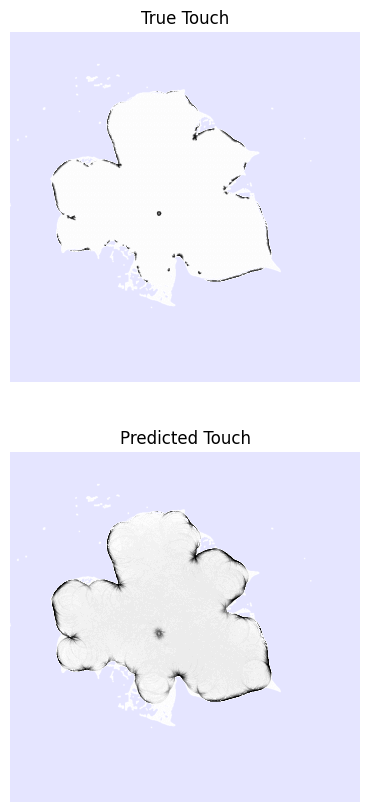

In [25]:
import matplotlib.colors as mcolors
colors = [(0.9, 0.9, 1), (1,1,1), (0,0,0)]  # R -> G -> B
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_colormap'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = mcolors.Normalize(vmin=-1, vmax=1)

a = -maze_map[:,:,world].cpu().detach().numpy()
b= touch_record_space.squeeze()
b[b == 0] = a[b == 0]
c= touch_predict_space.squeeze()
c[c == 0] = a[c == 0]
print(np.min(touch_record_space.squeeze(),(0,1)))
plt.figure(figsize=[5,10])
# plt.subplot(1,2,1)
# plt.imshow(maze_map[:,:,world].cpu().detach().numpy(),cmap='gray_r')
# plt.title('Arena')
# plt.axis('off')
plt.subplot(2,1,1)
plt.imshow(b[150:950,150:950],cmap=custom_cmap, norm=norm)
plt.title('True Touch')
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(c[150:950,150:950],cmap=custom_cmap, norm=norm)
plt.title('Predicted Touch')
plt.axis('off')
# plt.subplot(2,1,1)
# plt.imshow((touch_record_space.squeeze()),cmap = 'gray_r')#cmap=custom_cmap, norm=norm)
# plt.title('True Touch')
# plt.axis('off')
# plt.subplot(2,1,2)
# plt.imshow((touch_predict_space.squeeze()),cmap = 'gray_r')#cmap=custom_cmap, norm=norm)
# plt.title('Predicted Touch')
# plt.axis('off')

